In [1]:
import os
import random
import pickle
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision

from models.vt_resnet import vt_resnet18
from datasets.image_net import ImageNetDataset
from models.train import train, evaluate
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam
from torchsummary import summary
from pprint import pprint

In [2]:
%load_ext autoreload
%autoreload 2

# Utility Functions

In [3]:
def store_params(content, name):
    f = open(f'params/{name}.pkl','wb')
    pickle.dump(content, f)
    f.close()

def load_params(name):
    fl = open(f'params/{name}.pkl', "rb")
    loaded = pickle.load(fl)
    return loaded

def store_model(model, name):
    torch.save(model.state_dict(), f'./trained_models/{name}.pth')
                                                

# Constants

In [4]:
batch_size = 128
input_dim = 224
num_classes = 100

# Preparing Data

In [5]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((input_dim, input_dim))
    ])
train_dataset = ImageNetDataset(train=True, num_classes=num_classes, transform=transform)
valid_dataset = ImageNetDataset(train=False, num_classes=num_classes, transform=transform)

In [7]:
len(train_dataset), len(valid_dataset)

(126100, 5000)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

total_valid_num = len(valid_dataset)
total_train_num = len(train_dataset)
valid_num = int(0.6 * total_valid_num)

valid_mask = list(range(valid_num))
test_mask = list(range(valid_num, total_valid_num))

valid_loader = DataLoader(Subset(valid_dataset, valid_mask), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(Subset(valid_dataset, test_mask), batch_size=batch_size, shuffle=True)

small_train_mask = random.sample(range(total_train_num), 1200)
medium_train_mask = random.sample(range(total_train_num), 5000)
small_valid_mask = random.sample(range(total_valid_num), 200)

small_train_loader = DataLoader(Subset(train_dataset, list(small_train_mask)), batch_size=batch_size, 
                                shuffle=True, num_workers=2)
small_valid_loader = DataLoader(Subset(valid_dataset, list(small_valid_mask)), batch_size=batch_size, 
                                shuffle=True, num_workers=2)

medium_loader = DataLoader(Subset(train_dataset, list(medium_train_mask)), batch_size=batch_size, shuffle=True)

# Parameters

In [8]:
tokens = 16
token_channels = 1024
vt_channels = 512
transformer_enc_layers = 3
transformer_heads = 8

learning_rate = 1e-2
weight_decay = 4e-5

# Hyperparameter Search

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [15]:
def param_search():

    l = 0.005
    r = 0.004
    lr_trials = 1
    lrs = [0.0008, 0.002]
    Ls = [8, 16]
    Ns = [128]
    Ds = [512]
    optims = [torch.optim.Adam]
    weight_decay = 4e-4
    lr_decay = 0.1
    decay_every = 30
    epochs = 20
    enc_layers = [2]
    n_heads = [8]
    fc_dims = [512]
    t_dropout = [0.5]
    vt_channels_lst = [512]
    vt_num_layers = [2]
    input_dim = 224
    num_classes=100
    

    best_model = None
    best = {}
    best['valid_acc'] = 0

    all_count = 14
    best_count = 0
    counter = 0

    for N in Ns:
        train_loader = DataLoader(train_dataset, batch_size=N, shuffle=True, num_workers=4)
        for D in Ds:
            for optim in optims:
                for vt_channels in vt_channels_lst:
                    for n_head in n_heads:
                        for fc_dim in fc_dims:
                            for dropout in t_dropout:
                                for enc_layer in enc_layers: 
                                    for L in Ls: 
                                        for lr in lrs:
                                            for vt_num_layer in vt_num_layers:
                                        
                                                
                                                model = vt_resnet18(
                                                        pretrained=True,
                                                        tokens=L,
                                                        token_channels=D,
                                                        input_dim=input_dim,
                                                        vt_channels=vt_channels,
                                                        transformer_enc_layers=enc_layer,
                                                        transformer_heads=n_head,
                                                        transformer_fc_dim=fc_dim,
                                                        transformer_dropout=dropout,
                                                        num_classes=num_classes,
                                                    )
                                                model.to(device)
                                                print(device)
                                                summary(model, (3, input_dim, input_dim))
                                            
                                                optimizer = optim(model.parameters(), lr=lr, weight_decay=weight_decay)

                                                valid_acc, train_acc, all_hist = train(
                                                    model, 
                                                    optimizer, 
                                                    train_loader, 
                                                    valid_loader, 
                                                    epochs,
                                                    lr,
                                                    lr_decay,
                                                    decay_every,
                                                    weight_decay,
                                                    optim,
                                                    device=device,
                                                    optimize=True,
                                                    threshold_acc=40.0,
                                                    threshold_itr=5
                                                    )
                                                
                                                valid_acc = valid_acc.to('cpu')
                                                train_acc = train_acc.to('cpu')

                                                plt.figure(figsize=(20,9))
                                                plt.plot(all_hist)
                                                
                                                store_name = 'attempt'
                                                while os.path.exists(os.path.join('./trained_models', store_name + str(counter) + '.pth')):
                                                    counter += 1
                                                store_model(model, store_name + str(counter))
                                                
                                                params = {
                                                    'valid_acc': valid_acc,
                                                    'train_acc': train_acc,
                                                    'lr': lr,
                                                    'L': L,
                                                    'N': N,
                                                    'D': D,
                                                    'optim': optim,
                                                    'enc_layer': enc_layer,
                                                    'fc_dim': fc_dim,
                                                    'vt_channels': vt_channels,
                                                    'dropout': dropout,
                                                    'n_head': n_head,
                                                    'num_classes':num_classes,
                                                    'epochs':epochs
                                                }
                                                store_params(params, store_name + str(counter))
                                                if valid_acc > best['valid_acc']:
                                                    best_model = model
                                                    best = params
   
                                                
                                                print("This Epoch Params:")
                                                pprint(params)
                                                print("\n")

                                                print('Best So Far:')
                                                pprint(best)

            

    return best, best_model

  0%|          | 0/986 [00:00<?, ?it/s]

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [

/kuacc/users/nnayal17/.conda/envs/nazir_env/lib/python3.8/site-packages/torchvision/transforms/functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/kuacc/users/nnayal17/.conda/envs/nazir_env/lib/python3.8/site-packages/torchvision/transforms/functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its dat

[    0/126100 (  0%)]  Loss: 4.6557


 10%|█         | 101/986 [00:43<06:09,  2.39it/s]

[12800/126100 ( 10%)]  Loss: 4.6030


 20%|██        | 201/986 [01:25<05:29,  2.38it/s]

[25600/126100 ( 20%)]  Loss: 4.5073


 31%|███       | 301/986 [02:08<04:48,  2.38it/s]

[38400/126100 ( 30%)]  Loss: 4.4488


 41%|████      | 401/986 [02:50<04:06,  2.37it/s]

[51200/126100 ( 41%)]  Loss: 4.3423


 51%|█████     | 501/986 [03:32<03:24,  2.37it/s]

[64000/126100 ( 51%)]  Loss: 4.2705


 61%|██████    | 601/986 [04:15<02:43,  2.35it/s]

[76800/126100 ( 61%)]  Loss: 4.2600


 71%|███████   | 701/986 [04:57<02:01,  2.35it/s]

[89600/126100 ( 71%)]  Loss: 4.1225


 81%|████████  | 801/986 [05:40<01:18,  2.36it/s]

[102400/126100 ( 81%)]  Loss: 3.9919


 91%|█████████▏| 901/986 [06:22<00:36,  2.35it/s]

[115200/126100 ( 91%)]  Loss: 4.0283


  0%|          | 0/24 [00:00<?, ?it/s]/kuacc/users/nnayal17/.conda/envs/nazir_env/lib/python3.8/site-packages/torchvision/transforms/functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


Epoch 0 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 3.9196  Accuracy:  189/ 3000 (6.30%)



  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 3.9459  Accuracy: 8123/126100 (6.44%)



  0%|          | 1/986 [00:02<33:03,  2.01s/it]

[    0/126100 (  0%)]  Loss: 3.9106


 10%|█         | 101/986 [00:44<06:13,  2.37it/s]

[12800/126100 ( 10%)]  Loss: 3.8311


 20%|██        | 201/986 [01:26<05:32,  2.36it/s]

[25600/126100 ( 20%)]  Loss: 3.8937


 31%|███       | 301/986 [02:09<04:53,  2.34it/s]

[38400/126100 ( 30%)]  Loss: 3.6864


 41%|████      | 401/986 [02:52<04:08,  2.35it/s]

[51200/126100 ( 41%)]  Loss: 3.6231


 51%|█████     | 501/986 [03:35<03:28,  2.33it/s]

[64000/126100 ( 51%)]  Loss: 3.6719


 61%|██████    | 601/986 [04:18<02:44,  2.35it/s]

[76800/126100 ( 61%)]  Loss: 3.6164


 71%|███████   | 701/986 [05:01<02:04,  2.28it/s]

[89600/126100 ( 71%)]  Loss: 3.5801


 81%|████████  | 801/986 [05:44<01:20,  2.30it/s]

[102400/126100 ( 81%)]  Loss: 3.4595


 91%|█████████▏| 901/986 [06:27<00:37,  2.26it/s]

[115200/126100 ( 91%)]  Loss: 3.3816


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 1 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 3.4215  Accuracy:  385/ 3000 (12.83%)



  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 3.4112  Accuracy:17158/126100 (13.61%)



  0%|          | 1/986 [00:01<26:40,  1.62s/it]

[    0/126100 (  0%)]  Loss: 3.4534


 10%|█         | 101/986 [00:43<06:20,  2.33it/s]

[12800/126100 ( 10%)]  Loss: 3.2270


 20%|██        | 201/986 [01:26<05:49,  2.24it/s]

[25600/126100 ( 20%)]  Loss: 3.4801


 31%|███       | 301/986 [02:09<04:53,  2.34it/s]

[38400/126100 ( 30%)]  Loss: 3.4062


 41%|████      | 401/986 [02:52<04:12,  2.32it/s]

[51200/126100 ( 41%)]  Loss: 3.0929


 51%|█████     | 501/986 [03:35<03:33,  2.27it/s]

[64000/126100 ( 51%)]  Loss: 3.2045


 61%|██████    | 601/986 [04:18<02:47,  2.30it/s]

[76800/126100 ( 61%)]  Loss: 3.1035


 71%|███████   | 701/986 [05:02<02:02,  2.33it/s]

[89600/126100 ( 71%)]  Loss: 3.1209


 81%|████████  | 801/986 [05:45<01:18,  2.34it/s]

[102400/126100 ( 81%)]  Loss: 3.1272


 91%|█████████▏| 901/986 [06:27<00:36,  2.33it/s]

[115200/126100 ( 91%)]  Loss: 2.9991


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 2.9869  Accuracy:  610/ 3000 (20.33%)



  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 2.9594  Accuracy:27867/126100 (22.10%)



  0%|          | 1/986 [00:01<28:10,  1.72s/it]

[    0/126100 (  0%)]  Loss: 2.9478


 10%|█         | 101/986 [00:43<06:12,  2.37it/s]

[12800/126100 ( 10%)]  Loss: 2.8956


 20%|██        | 201/986 [01:26<05:36,  2.33it/s]

[25600/126100 ( 20%)]  Loss: 2.7290


 31%|███       | 301/986 [02:09<05:01,  2.27it/s]

[38400/126100 ( 30%)]  Loss: 2.6410


 41%|████      | 401/986 [02:52<04:09,  2.34it/s]

[51200/126100 ( 41%)]  Loss: 2.6405


 51%|█████     | 501/986 [03:35<03:29,  2.32it/s]

[64000/126100 ( 51%)]  Loss: 2.6243


 61%|██████    | 601/986 [04:18<02:44,  2.34it/s]

[76800/126100 ( 61%)]  Loss: 2.5441


 71%|███████   | 701/986 [05:01<02:02,  2.32it/s]

[89600/126100 ( 71%)]  Loss: 2.5079


 81%|████████  | 801/986 [05:45<01:19,  2.34it/s]

[102400/126100 ( 81%)]  Loss: 2.2943


 91%|█████████▏| 901/986 [06:28<00:36,  2.34it/s]

[115200/126100 ( 91%)]  Loss: 2.4963


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 2.3860  Accuracy: 1018/ 3000 (33.93%)



  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 2.2896  Accuracy:46909/126100 (37.20%)



  0%|          | 1/986 [00:01<30:31,  1.86s/it]

[    0/126100 (  0%)]  Loss: 2.3945


 10%|█         | 101/986 [00:44<06:24,  2.30it/s]

[12800/126100 ( 10%)]  Loss: 2.3406


 20%|██        | 201/986 [01:27<05:33,  2.35it/s]

[25600/126100 ( 20%)]  Loss: 2.5085


 31%|███       | 301/986 [02:11<05:03,  2.26it/s]

[38400/126100 ( 30%)]  Loss: 2.2445


 41%|████      | 401/986 [02:54<04:12,  2.31it/s]

[51200/126100 ( 41%)]  Loss: 2.0178


 51%|█████     | 501/986 [03:37<03:29,  2.31it/s]

[64000/126100 ( 51%)]  Loss: 2.0187


 61%|██████    | 601/986 [04:21<02:50,  2.26it/s]

[76800/126100 ( 61%)]  Loss: 2.0580


 71%|███████   | 701/986 [05:04<02:04,  2.29it/s]

[89600/126100 ( 71%)]  Loss: 2.0688


 81%|████████  | 801/986 [05:48<01:20,  2.31it/s]

[102400/126100 ( 81%)]  Loss: 1.9455


 91%|█████████▏| 901/986 [06:31<00:36,  2.33it/s]

[115200/126100 ( 91%)]  Loss: 1.9564


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 1.9845  Accuracy: 1343/ 3000 (44.77%)



  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 1.8305  Accuracy:61615/126100 (48.86%)



  0%|          | 1/986 [00:01<30:33,  1.86s/it]

[    0/126100 (  0%)]  Loss: 1.6355


 10%|█         | 101/986 [00:44<06:20,  2.33it/s]

[12800/126100 ( 10%)]  Loss: 1.9489


 20%|██        | 201/986 [01:27<05:34,  2.35it/s]

[25600/126100 ( 20%)]  Loss: 1.8105


 31%|███       | 301/986 [02:10<04:52,  2.34it/s]

[38400/126100 ( 30%)]  Loss: 1.6528


 41%|████      | 401/986 [02:53<04:10,  2.34it/s]

[51200/126100 ( 41%)]  Loss: 1.7326


 51%|█████     | 501/986 [03:36<03:31,  2.30it/s]

[64000/126100 ( 51%)]  Loss: 1.5817


 61%|██████    | 601/986 [04:19<02:49,  2.27it/s]

[76800/126100 ( 61%)]  Loss: 1.6954


 71%|███████   | 701/986 [05:02<02:02,  2.33it/s]

[89600/126100 ( 71%)]  Loss: 1.8544


 81%|████████  | 801/986 [05:45<01:22,  2.24it/s]

[102400/126100 ( 81%)]  Loss: 1.6322


 91%|█████████▏| 901/986 [06:29<00:36,  2.34it/s]

[115200/126100 ( 91%)]  Loss: 1.7573


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 1.7650  Accuracy: 1502/ 3000 (50.07%)



  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 1.4951  Accuracy:72283/126100 (57.32%)



  0%|          | 1/986 [00:01<32:00,  1.95s/it]

[    0/126100 (  0%)]  Loss: 1.5444


 10%|█         | 101/986 [00:44<06:16,  2.35it/s]

[12800/126100 ( 10%)]  Loss: 1.6088


 20%|██        | 201/986 [01:26<05:36,  2.33it/s]

[25600/126100 ( 20%)]  Loss: 1.7127


 31%|███       | 301/986 [02:09<04:56,  2.31it/s]

[38400/126100 ( 30%)]  Loss: 1.3701


 41%|████      | 401/986 [02:52<04:10,  2.34it/s]

[51200/126100 ( 41%)]  Loss: 1.6656


 51%|█████     | 501/986 [03:35<03:27,  2.34it/s]

[64000/126100 ( 51%)]  Loss: 1.7949


 61%|██████    | 601/986 [04:18<02:43,  2.35it/s]

[76800/126100 ( 61%)]  Loss: 1.4644


 71%|███████   | 701/986 [05:01<02:01,  2.34it/s]

[89600/126100 ( 71%)]  Loss: 1.6613


 81%|████████  | 801/986 [05:44<01:18,  2.34it/s]

[102400/126100 ( 81%)]  Loss: 1.4327


 91%|█████████▏| 901/986 [06:27<00:37,  2.29it/s]

[115200/126100 ( 91%)]  Loss: 1.6902


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 1.6586  Accuracy: 1566/ 3000 (52.20%)



  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 1.3088  Accuracy:78873/126100 (62.55%)



  0%|          | 1/986 [00:01<29:49,  1.82s/it]

[    0/126100 (  0%)]  Loss: 1.1722


 10%|█         | 101/986 [00:44<06:20,  2.33it/s]

[12800/126100 ( 10%)]  Loss: 1.1550


 20%|██        | 201/986 [01:26<05:36,  2.34it/s]

[25600/126100 ( 20%)]  Loss: 1.2182


 31%|███       | 301/986 [02:09<04:55,  2.32it/s]

[38400/126100 ( 30%)]  Loss: 1.1865


 41%|████      | 401/986 [02:52<04:11,  2.33it/s]

[51200/126100 ( 41%)]  Loss: 1.3990


 51%|█████     | 501/986 [03:35<03:26,  2.35it/s]

[64000/126100 ( 51%)]  Loss: 1.2193


 61%|██████    | 601/986 [04:18<02:44,  2.34it/s]

[76800/126100 ( 61%)]  Loss: 1.4264


 71%|███████   | 701/986 [05:01<02:01,  2.34it/s]

[89600/126100 ( 71%)]  Loss: 1.1999


 81%|████████  | 801/986 [05:44<01:19,  2.34it/s]

[102400/126100 ( 81%)]  Loss: 1.1590


 91%|█████████▏| 901/986 [06:27<00:36,  2.33it/s]

[115200/126100 ( 91%)]  Loss: 1.1409


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 1.5660  Accuracy: 1678/ 3000 (55.93%)



  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 1.1153  Accuracy:85497/126100 (67.80%)



  0%|          | 1/986 [00:01<29:16,  1.78s/it]

[    0/126100 (  0%)]  Loss: 1.1689


 10%|█         | 101/986 [00:44<06:18,  2.34it/s]

[12800/126100 ( 10%)]  Loss: 1.0244


 20%|██        | 201/986 [01:27<05:40,  2.30it/s]

[25600/126100 ( 20%)]  Loss: 0.8853


 31%|███       | 301/986 [02:10<05:01,  2.27it/s]

[38400/126100 ( 30%)]  Loss: 0.8386


 41%|████      | 401/986 [02:53<04:13,  2.31it/s]

[51200/126100 ( 41%)]  Loss: 1.0824


 51%|█████     | 501/986 [03:36<03:29,  2.31it/s]

[64000/126100 ( 51%)]  Loss: 1.0922


 61%|██████    | 601/986 [04:20<02:46,  2.32it/s]

[76800/126100 ( 61%)]  Loss: 1.0886


 71%|███████   | 701/986 [05:03<02:04,  2.28it/s]

[89600/126100 ( 71%)]  Loss: 1.0400


 81%|████████  | 801/986 [05:46<01:19,  2.32it/s]

[102400/126100 ( 81%)]  Loss: 1.2811


 91%|█████████▏| 901/986 [06:30<00:36,  2.33it/s]

[115200/126100 ( 91%)]  Loss: 1.0502


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 1.4836  Accuracy: 1787/ 3000 (59.57%)



  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 0.9179  Accuracy:92073/126100 (73.02%)



  0%|          | 1/986 [00:01<29:42,  1.81s/it]

[    0/126100 (  0%)]  Loss: 0.9799


 10%|█         | 101/986 [00:44<06:14,  2.36it/s]

[12800/126100 ( 10%)]  Loss: 0.9156


 20%|██        | 201/986 [01:26<05:35,  2.34it/s]

[25600/126100 ( 20%)]  Loss: 0.8596


 31%|███       | 301/986 [02:09<04:53,  2.33it/s]

[38400/126100 ( 30%)]  Loss: 0.8243


 41%|████      | 401/986 [02:52<04:14,  2.30it/s]

[51200/126100 ( 41%)]  Loss: 0.8191


 51%|█████     | 501/986 [03:35<03:27,  2.34it/s]

[64000/126100 ( 51%)]  Loss: 0.9054


 61%|██████    | 601/986 [04:18<02:44,  2.34it/s]

[76800/126100 ( 61%)]  Loss: 0.7970


 71%|███████   | 701/986 [05:02<02:01,  2.34it/s]

[89600/126100 ( 71%)]  Loss: 0.9880


 81%|████████  | 801/986 [05:45<01:19,  2.34it/s]

[102400/126100 ( 81%)]  Loss: 1.0667


  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 0.7619  Accuracy:98190/126100 (77.87%)



  0%|          | 1/986 [00:01<32:15,  1.97s/it]

[    0/126100 (  0%)]  Loss: 0.5927


 10%|█         | 101/986 [00:44<06:11,  2.38it/s]

[12800/126100 ( 10%)]  Loss: 0.8184


 20%|██        | 201/986 [01:27<05:32,  2.36it/s]

[25600/126100 ( 20%)]  Loss: 0.6300


 31%|███       | 301/986 [02:09<04:54,  2.33it/s]

[38400/126100 ( 30%)]  Loss: 0.6928


 41%|████      | 401/986 [02:52<04:09,  2.34it/s]

[51200/126100 ( 41%)]  Loss: 0.7725


 51%|█████     | 501/986 [03:35<03:29,  2.32it/s]

[64000/126100 ( 51%)]  Loss: 0.6983


 61%|██████    | 601/986 [04:18<02:48,  2.28it/s]

[76800/126100 ( 61%)]  Loss: 0.7631


 71%|███████   | 701/986 [05:01<02:02,  2.32it/s]

[89600/126100 ( 71%)]  Loss: 0.7373


 81%|████████  | 801/986 [05:44<01:19,  2.34it/s]

[102400/126100 ( 81%)]  Loss: 0.6549


 91%|█████████▏| 901/986 [06:27<00:36,  2.33it/s]

[115200/126100 ( 91%)]  Loss: 0.8074


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 1.4400  Accuracy: 1834/ 3000 (61.13%)



  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 0.6470  Accuracy:102310/126100 (81.13%)



  0%|          | 1/986 [00:01<27:23,  1.67s/it]

[    0/126100 (  0%)]  Loss: 0.5568


 10%|█         | 101/986 [00:44<06:19,  2.34it/s]

[12800/126100 ( 10%)]  Loss: 0.7328


 14%|█▍        | 137/986 [00:59<06:01,  2.35it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 31%|███       | 301/986 [02:09<04:51,  2.35it/s]

[38400/126100 ( 30%)]  Loss: 0.3198


 41%|████      | 401/986 [02:52<04:09,  2.34it/s]

[51200/126100 ( 41%)]  Loss: 0.2868


 51%|█████     | 501/986 [03:35<03:26,  2.35it/s]

[64000/126100 ( 51%)]  Loss: 0.2751


 61%|██████    | 601/986 [04:18<02:43,  2.35it/s]

[76800/126100 ( 61%)]  Loss: 0.3558


 71%|███████   | 701/986 [05:01<02:02,  2.33it/s]

[89600/126100 ( 71%)]  Loss: 0.3337


 81%|████████  | 801/986 [05:43<01:19,  2.31it/s]

[102400/126100 ( 81%)]  Loss: 0.3818


 91%|█████████▏| 901/986 [06:26<00:36,  2.34it/s]

[115200/126100 ( 91%)]  Loss: 0.2722


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 1.5973  Accuracy: 1851/ 3000 (61.70%)



  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 0.2846  Accuracy:116992/126100 (92.78%)



  0%|          | 1/986 [00:01<29:52,  1.82s/it]

[    0/126100 (  0%)]  Loss: 0.3228


 10%|█         | 101/986 [00:44<06:13,  2.37it/s]

[12800/126100 ( 10%)]  Loss: 0.2388


 20%|██        | 201/986 [01:26<05:35,  2.34it/s]

[25600/126100 ( 20%)]  Loss: 0.2780


 31%|███       | 301/986 [02:09<04:53,  2.33it/s]

[38400/126100 ( 30%)]  Loss: 0.2533


 41%|████      | 401/986 [02:52<04:09,  2.34it/s]

[51200/126100 ( 41%)]  Loss: 0.2576


 51%|█████     | 501/986 [03:35<03:28,  2.33it/s]

[64000/126100 ( 51%)]  Loss: 0.2921


 61%|██████    | 601/986 [04:17<02:43,  2.36it/s]

[76800/126100 ( 61%)]  Loss: 0.3911


 71%|███████   | 701/986 [05:00<02:02,  2.33it/s]

[89600/126100 ( 71%)]  Loss: 0.4346


 81%|████████  | 801/986 [05:43<01:19,  2.33it/s]

[102400/126100 ( 81%)]  Loss: 0.3143


 91%|█████████▏| 901/986 [06:26<00:36,  2.34it/s]

[115200/126100 ( 91%)]  Loss: 0.3012


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 1.5921  Accuracy: 1871/ 3000 (62.37%)



 25%|██▍       | 244/986 [01:13<03:48,  3.25it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 31%|███       | 301/986 [02:09<04:52,  2.34it/s]

[38400/126100 ( 30%)]  Loss: 2.5102


 41%|████      | 401/986 [02:52<04:13,  2.31it/s]

[51200/126100 ( 41%)]  Loss: 2.9884


 51%|█████     | 501/986 [03:35<03:27,  2.34it/s]

[64000/126100 ( 51%)]  Loss: 2.5602


 61%|██████    | 601/986 [04:18<02:44,  2.35it/s]

[76800/126100 ( 61%)]  Loss: 2.5151


 71%|███████   | 701/986 [05:01<02:03,  2.30it/s]

[89600/126100 ( 71%)]  Loss: 2.5852


 81%|████████  | 801/986 [05:44<01:18,  2.35it/s]

[102400/126100 ( 81%)]  Loss: 2.5480


 91%|█████████▏| 901/986 [06:27<00:36,  2.34it/s]

[115200/126100 ( 91%)]  Loss: 2.0344


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 2.2647  Accuracy: 1117/ 3000 (37.23%)



  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 2.2126  Accuracy:48991/126100 (38.85%)



  0%|          | 1/986 [00:01<29:32,  1.80s/it]

[    0/126100 (  0%)]  Loss: 2.3596


 10%|█         | 101/986 [00:44<06:17,  2.35it/s]

[12800/126100 ( 10%)]  Loss: 2.2005


 20%|██        | 201/986 [01:26<05:36,  2.33it/s]

[25600/126100 ( 20%)]  Loss: 2.0177


 31%|███       | 301/986 [02:09<04:53,  2.34it/s]

[38400/126100 ( 30%)]  Loss: 1.9293


 41%|████      | 401/986 [02:52<04:11,  2.33it/s]

[51200/126100 ( 41%)]  Loss: 2.0678


 51%|█████     | 501/986 [03:35<03:27,  2.34it/s]

[64000/126100 ( 51%)]  Loss: 2.0378


 61%|██████    | 601/986 [04:18<02:45,  2.33it/s]

[76800/126100 ( 61%)]  Loss: 1.7877


 71%|███████   | 701/986 [05:01<02:01,  2.34it/s]

[89600/126100 ( 71%)]  Loss: 1.7610


 81%|████████  | 801/986 [05:44<01:18,  2.35it/s]

[102400/126100 ( 81%)]  Loss: 1.7892


 91%|█████████▏| 901/986 [06:27<00:36,  2.32it/s]

[115200/126100 ( 91%)]  Loss: 2.0199


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 1.9131  Accuracy: 1405/ 3000 (46.83%)



 26%|██▌       | 255/986 [01:16<03:35,  3.39it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 0.6930  Accuracy:100500/126100 (79.70%)



  0%|          | 1/986 [00:01<30:40,  1.87s/it]

[    0/126100 (  0%)]  Loss: 0.6572


 10%|█         | 101/986 [00:44<06:18,  2.34it/s]

[12800/126100 ( 10%)]  Loss: 0.7018


 20%|██        | 201/986 [01:27<05:38,  2.32it/s]

[25600/126100 ( 20%)]  Loss: 0.6780


 31%|███       | 301/986 [02:10<04:59,  2.29it/s]

[38400/126100 ( 30%)]  Loss: 0.8133


 41%|████      | 401/986 [02:53<04:09,  2.34it/s]

[51200/126100 ( 41%)]  Loss: 0.7682


 51%|█████     | 501/986 [03:35<03:26,  2.34it/s]

[64000/126100 ( 51%)]  Loss: 0.6927


 61%|██████    | 601/986 [04:18<02:44,  2.33it/s]

[76800/126100 ( 61%)]  Loss: 0.6867


 71%|███████   | 701/986 [05:01<02:03,  2.31it/s]

[89600/126100 ( 71%)]  Loss: 0.8036


 81%|████████  | 801/986 [05:44<01:19,  2.34it/s]

[102400/126100 ( 81%)]  Loss: 0.8418


 91%|█████████▏| 901/986 [06:27<00:37,  2.28it/s]

[115200/126100 ( 91%)]  Loss: 0.7162


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 1.5057  Accuracy: 1807/ 3000 (60.23%)



  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 0.7178  Accuracy:98933/126100 (78.46%)



  0%|          | 1/986 [00:01<30:33,  1.86s/it]

[    0/126100 (  0%)]  Loss: 0.7879


 10%|█         | 101/986 [00:44<06:15,  2.36it/s]

[12800/126100 ( 10%)]  Loss: 0.4585


 13%|█▎        | 129/986 [00:56<06:07,  2.33it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 0.4483  Accuracy:108596/126100 (86.12%)



  0%|          | 1/986 [00:01<32:39,  1.99s/it]

[    0/126100 (  0%)]  Loss: 0.2937


 10%|█         | 101/986 [00:44<06:21,  2.32it/s]

[12800/126100 ( 10%)]  Loss: 0.2773


 20%|██        | 201/986 [01:27<05:35,  2.34it/s]

[25600/126100 ( 20%)]  Loss: 0.3197


 31%|███       | 301/986 [02:09<04:51,  2.35it/s]

[38400/126100 ( 30%)]  Loss: 0.3913


 41%|████      | 401/986 [02:52<04:10,  2.34it/s]

[51200/126100 ( 41%)]  Loss: 0.3354


 51%|█████     | 501/986 [03:35<03:26,  2.35it/s]

[64000/126100 ( 51%)]  Loss: 0.3622


 61%|██████    | 601/986 [04:18<02:43,  2.35it/s]

[76800/126100 ( 61%)]  Loss: 0.2975


 71%|███████   | 701/986 [05:01<02:02,  2.33it/s]

[89600/126100 ( 71%)]  Loss: 0.4008


 81%|████████  | 801/986 [05:44<01:21,  2.26it/s]

[102400/126100 ( 81%)]  Loss: 0.3569


 91%|█████████▏| 901/986 [06:27<00:36,  2.34it/s]

[115200/126100 ( 91%)]  Loss: 0.3432


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 1.5479  Accuracy: 1851/ 3000 (61.70%)



  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 0.2866  Accuracy:116170/126100 (92.13%)



  0%|          | 1/986 [00:02<38:03,  2.32s/it]

[    0/126100 (  0%)]  Loss: 0.4178


 10%|█         | 101/986 [00:44<06:15,  2.36it/s]

[12800/126100 ( 10%)]  Loss: 0.3087


 20%|██        | 201/986 [01:27<05:34,  2.35it/s]

[25600/126100 ( 20%)]  Loss: 0.1865


 31%|███       | 301/986 [02:10<05:05,  2.25it/s]

[38400/126100 ( 30%)]  Loss: 0.3144


 41%|████      | 401/986 [02:53<04:10,  2.34it/s]

[51200/126100 ( 41%)]  Loss: 0.3224


 49%|████▉     | 482/986 [03:28<03:34,  2.34it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 0.3690  Accuracy:112084/126100 (88.89%)



  0%|          | 1/986 [00:01<31:05,  1.89s/it]

[    0/126100 (  0%)]  Loss: 0.2880


 10%|█         | 101/986 [00:44<06:14,  2.36it/s]

[12800/126100 ( 10%)]  Loss: 0.1455


 20%|██        | 201/986 [01:27<05:36,  2.34it/s]

[25600/126100 ( 20%)]  Loss: 0.2192


 31%|███       | 301/986 [02:10<04:53,  2.33it/s]

[38400/126100 ( 30%)]  Loss: 0.2103


 41%|████      | 401/986 [02:53<04:15,  2.29it/s]

[51200/126100 ( 41%)]  Loss: 0.2527


 51%|█████     | 501/986 [03:36<03:33,  2.27it/s]

[64000/126100 ( 51%)]  Loss: 0.3346


 61%|██████    | 601/986 [04:19<02:44,  2.35it/s]

[76800/126100 ( 61%)]  Loss: 0.2837


 71%|███████   | 701/986 [05:02<02:02,  2.33it/s]

[89600/126100 ( 71%)]  Loss: 0.3456


 81%|████████  | 801/986 [05:45<01:18,  2.34it/s]

[102400/126100 ( 81%)]  Loss: 0.2966


 91%|█████████▏| 901/986 [06:29<00:36,  2.33it/s]

[115200/126100 ( 91%)]  Loss: 0.3412


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 1.6010  Accuracy: 1878/ 3000 (62.60%)



  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 0.2819  Accuracy:115946/126100 (91.95%)



  0%|          | 1/986 [00:01<27:36,  1.68s/it]

[    0/126100 (  0%)]  Loss: 0.1767


 10%|█         | 101/986 [00:44<06:17,  2.34it/s]

[12800/126100 ( 10%)]  Loss: 0.2351


 20%|██        | 201/986 [01:27<05:37,  2.33it/s]

[25600/126100 ( 20%)]  Loss: 0.3406


 31%|███       | 301/986 [02:10<04:53,  2.34it/s]

[38400/126100 ( 30%)]  Loss: 0.1985


 41%|████      | 401/986 [02:53<04:15,  2.29it/s]

[51200/126100 ( 41%)]  Loss: 0.2514


 51%|█████     | 501/986 [03:36<03:33,  2.28it/s]

[64000/126100 ( 51%)]  Loss: 0.2449


 61%|██████    | 601/986 [04:20<02:56,  2.18it/s]

[76800/126100 ( 61%)]  Loss: 0.3025


 71%|███████   | 701/986 [05:03<02:04,  2.30it/s]

[89600/126100 ( 71%)]  Loss: 0.2382


 81%|████████  | 801/986 [05:46<01:19,  2.32it/s]

[102400/126100 ( 81%)]  Loss: 0.2097


 91%|█████████▏| 901/986 [06:29<00:36,  2.35it/s]

[115200/126100 ( 91%)]  Loss: 0.3341


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 1.7231  Accuracy: 1792/ 3000 (59.73%)



  0%|          | 0/24 [00:00<?, ?it/s]


Average train loss: 0.3164  Accuracy:113983/126100 (90.39%)



  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 1.7231  Accuracy: 1792/ 3000 (59.73%)



100%|██████████| 986/986 [04:52<00:00,  3.37it/s]



Average train loss: 0.3164  Accuracy:113983/126100 (90.39%)

This Epoch Params:
{'D': 512,
 'L': 8,
 'N': 128,
 'dropout': 0.5,
 'enc_layer': 2,
 'epochs': 20,
 'fc_dim': 512,
 'lr': 0.002,
 'n_head': 8,
 'num_classes': 100,
 'optim': <class 'torch.optim.adam.Adam'>,
 'train_acc': tensor(90.3910),
 'valid_acc': tensor(59.7333),
 'vt_channels': 512}


Best So Far:
{'D': 512,
 'L': 8,
 'N': 128,
 'dropout': 0.5,
 'enc_layer': 2,
 'epochs': 20,
 'fc_dim': 512,
 'lr': 0.0008,
 'n_head': 8,
 'num_classes': 100,
 'optim': <class 'torch.optim.adam.Adam'>,
 'train_acc': tensor(95.2458),
 'valid_acc': tensor(62.5333),
 'vt_channels': 512}


  0%|          | 0/986 [00:00<?, ?it/s]

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [

  0%|          | 1/986 [00:02<33:36,  2.05s/it]

[    0/126100 (  0%)]  Loss: 4.6910


 10%|█         | 101/986 [00:45<06:23,  2.31it/s]

[12800/126100 ( 10%)]  Loss: 4.6043


 20%|██        | 201/986 [01:29<05:45,  2.27it/s]

[25600/126100 ( 20%)]  Loss: 4.5922


 31%|███       | 301/986 [02:13<05:02,  2.26it/s]

[38400/126100 ( 30%)]  Loss: 4.5321


 41%|████      | 401/986 [02:57<04:17,  2.28it/s]

[51200/126100 ( 41%)]  Loss: 4.4574


 51%|█████     | 501/986 [03:50<03:33,  2.28it/s]

[64000/126100 ( 51%)]  Loss: 4.3100


 61%|██████    | 601/986 [04:34<02:51,  2.25it/s]

[76800/126100 ( 61%)]  Loss: 4.1455


 71%|███████   | 701/986 [05:18<02:05,  2.27it/s]

[89600/126100 ( 71%)]  Loss: 4.0275


 81%|████████  | 801/986 [06:02<01:24,  2.20it/s]

[102400/126100 ( 81%)]  Loss: 3.9999


 91%|█████████▏| 901/986 [06:47<00:39,  2.18it/s]

[115200/126100 ( 91%)]  Loss: 3.8645


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 0 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 3.8353  Accuracy:  219/ 3000 (7.30%)



  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 3.8716  Accuracy: 8817/126100 (6.99%)



  0%|          | 1/986 [00:01<30:42,  1.87s/it]

[    0/126100 (  0%)]  Loss: 3.9256


 10%|█         | 101/986 [00:45<06:29,  2.27it/s]

[12800/126100 ( 10%)]  Loss: 3.7675


 20%|██        | 201/986 [01:29<05:44,  2.28it/s]

[25600/126100 ( 20%)]  Loss: 3.8665


 31%|███       | 301/986 [02:13<05:00,  2.28it/s]

[38400/126100 ( 30%)]  Loss: 3.6282


 41%|████      | 401/986 [02:57<04:17,  2.27it/s]

[51200/126100 ( 41%)]  Loss: 3.5964


 51%|█████     | 501/986 [03:42<03:42,  2.18it/s]

[64000/126100 ( 51%)]  Loss: 3.4794


 61%|██████    | 601/986 [04:26<02:48,  2.29it/s]

[76800/126100 ( 61%)]  Loss: 3.4993


 71%|███████   | 701/986 [05:10<02:05,  2.27it/s]

[89600/126100 ( 71%)]  Loss: 3.5395


 81%|████████  | 801/986 [05:55<01:22,  2.23it/s]

[102400/126100 ( 81%)]  Loss: 3.2921


 91%|█████████▏| 901/986 [06:39<00:37,  2.28it/s]

[115200/126100 ( 91%)]  Loss: 3.4571


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 1 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 3.2404  Accuracy:  458/ 3000 (15.27%)



  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 3.2689  Accuracy:18444/126100 (14.63%)



  0%|          | 1/986 [00:01<31:31,  1.92s/it]

[    0/126100 (  0%)]  Loss: 3.2885


 10%|█         | 101/986 [00:45<06:25,  2.30it/s]

[12800/126100 ( 10%)]  Loss: 3.2273


 20%|██        | 201/986 [01:29<05:47,  2.26it/s]

[25600/126100 ( 20%)]  Loss: 3.0032


 31%|███       | 301/986 [02:13<05:02,  2.27it/s]

[38400/126100 ( 30%)]  Loss: 3.2294


 41%|████      | 401/986 [02:57<04:19,  2.25it/s]

[51200/126100 ( 41%)]  Loss: 3.3857


 51%|█████     | 501/986 [03:41<03:35,  2.25it/s]

[64000/126100 ( 51%)]  Loss: 2.9982


 61%|██████    | 601/986 [04:25<02:47,  2.30it/s]

[76800/126100 ( 61%)]  Loss: 2.9110


 71%|███████   | 701/986 [05:09<02:05,  2.28it/s]

[89600/126100 ( 71%)]  Loss: 2.9094


 81%|████████  | 801/986 [05:52<01:20,  2.29it/s]

[102400/126100 ( 81%)]  Loss: 3.2139


 91%|█████████▏| 901/986 [06:36<00:37,  2.25it/s]

[115200/126100 ( 91%)]  Loss: 2.8584


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 2.8652  Accuracy:  647/ 3000 (21.57%)



  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 2.8635  Accuracy:29487/126100 (23.38%)



  0%|          | 1/986 [00:01<30:12,  1.84s/it]

[    0/126100 (  0%)]  Loss: 2.8742


 10%|█         | 101/986 [00:45<06:23,  2.31it/s]

[12800/126100 ( 10%)]  Loss: 2.8529


 20%|██        | 201/986 [01:28<05:42,  2.29it/s]

[25600/126100 ( 20%)]  Loss: 2.6849


 31%|███       | 301/986 [02:12<05:00,  2.28it/s]

[38400/126100 ( 30%)]  Loss: 2.6822


 38%|███▊      | 371/986 [02:43<04:31,  2.27it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 2.1515  Accuracy:52541/126100 (41.67%)



  0%|          | 1/986 [00:01<30:53,  1.88s/it]

[    0/126100 (  0%)]  Loss: 2.4367


 10%|█         | 101/986 [00:45<06:23,  2.31it/s]

[12800/126100 ( 10%)]  Loss: 2.4171


 20%|██        | 201/986 [01:29<05:48,  2.25it/s]

[25600/126100 ( 20%)]  Loss: 2.2452


 31%|███       | 301/986 [02:13<05:02,  2.27it/s]

[38400/126100 ( 30%)]  Loss: 2.1383


 41%|████      | 401/986 [02:58<04:30,  2.16it/s]

[51200/126100 ( 41%)]  Loss: 1.9289


 51%|█████     | 501/986 [03:42<03:36,  2.24it/s]

[64000/126100 ( 51%)]  Loss: 1.9469


 61%|██████    | 601/986 [04:27<02:52,  2.24it/s]

[76800/126100 ( 61%)]  Loss: 2.1009


 71%|███████   | 701/986 [05:11<02:05,  2.26it/s]

[89600/126100 ( 71%)]  Loss: 2.1559


 81%|████████  | 801/986 [05:56<01:22,  2.24it/s]

[102400/126100 ( 81%)]  Loss: 1.9367


 91%|█████████▏| 901/986 [06:41<00:37,  2.28it/s]

[115200/126100 ( 91%)]  Loss: 1.7502


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 2.2312  Accuracy: 1187/ 3000 (39.57%)



  0%|          | 0/24 [00:00<?, ?it/s]


Average train loss: 2.1320  Accuracy:53777/126100 (42.65%)

Training Aborted due to Poor Performance.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 2.2312  Accuracy: 1187/ 3000 (39.57%)



100%|██████████| 986/986 [04:56<00:00,  3.33it/s]



Average train loss: 2.1320  Accuracy:53777/126100 (42.65%)

This Epoch Params:
{'D': 512,
 'L': 16,
 'N': 128,
 'dropout': 0.5,
 'enc_layer': 2,
 'epochs': 20,
 'fc_dim': 512,
 'lr': 0.0008,
 'n_head': 8,
 'num_classes': 100,
 'optim': <class 'torch.optim.adam.Adam'>,
 'train_acc': tensor(42.6463),
 'valid_acc': tensor(39.5667),
 'vt_channels': 512}


Best So Far:
{'D': 512,
 'L': 8,
 'N': 128,
 'dropout': 0.5,
 'enc_layer': 2,
 'epochs': 20,
 'fc_dim': 512,
 'lr': 0.0008,
 'n_head': 8,
 'num_classes': 100,
 'optim': <class 'torch.optim.adam.Adam'>,
 'train_acc': tensor(95.2458),
 'valid_acc': tensor(62.5333),
 'vt_channels': 512}


  0%|          | 0/986 [00:00<?, ?it/s]

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [

  0%|          | 1/986 [00:01<32:40,  1.99s/it]

[    0/126100 (  0%)]  Loss: 4.6482


 10%|█         | 101/986 [00:45<06:25,  2.30it/s]

[12800/126100 ( 10%)]  Loss: 4.5793


 20%|██        | 201/986 [01:29<05:43,  2.29it/s]

[25600/126100 ( 20%)]  Loss: 4.4337


 31%|███       | 301/986 [02:13<04:59,  2.29it/s]

[38400/126100 ( 30%)]  Loss: 4.2437


 41%|████      | 401/986 [02:58<04:21,  2.23it/s]

[51200/126100 ( 41%)]  Loss: 4.1323


 51%|█████     | 501/986 [03:42<03:32,  2.29it/s]

[64000/126100 ( 51%)]  Loss: 4.0917


 61%|██████    | 601/986 [04:26<02:48,  2.29it/s]

[76800/126100 ( 61%)]  Loss: 4.1495


 71%|███████   | 701/986 [05:10<02:06,  2.26it/s]

[89600/126100 ( 71%)]  Loss: 4.0872


 81%|████████  | 801/986 [05:54<01:21,  2.27it/s]

[102400/126100 ( 81%)]  Loss: 3.9862


 91%|█████████▏| 901/986 [06:38<00:37,  2.28it/s]

[115200/126100 ( 91%)]  Loss: 3.9248


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 0 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 3.8319  Accuracy:  224/ 3000 (7.47%)



  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 3.8457  Accuracy: 9514/126100 (7.54%)



  0%|          | 1/986 [00:01<28:56,  1.76s/it]

[    0/126100 (  0%)]  Loss: 3.8891


 10%|█         | 101/986 [00:45<06:26,  2.29it/s]

[12800/126100 ( 10%)]  Loss: 3.9321


 20%|██        | 201/986 [01:29<05:44,  2.28it/s]

[25600/126100 ( 20%)]  Loss: 3.9861


 31%|███       | 301/986 [02:13<04:59,  2.28it/s]

[38400/126100 ( 30%)]  Loss: 4.3696


 41%|████      | 401/986 [02:57<04:22,  2.23it/s]

[51200/126100 ( 41%)]  Loss: 4.1793


 51%|█████     | 501/986 [03:42<03:33,  2.28it/s]

[64000/126100 ( 51%)]  Loss: 4.5721


 61%|██████    | 601/986 [04:26<02:49,  2.27it/s]

[76800/126100 ( 61%)]  Loss: 4.2710


 71%|███████   | 701/986 [05:11<02:07,  2.24it/s]

[89600/126100 ( 71%)]  Loss: 4.4390


 81%|████████  | 801/986 [05:55<01:21,  2.27it/s]

[102400/126100 ( 81%)]  Loss: 4.3769


 91%|█████████▏| 901/986 [06:40<00:37,  2.28it/s]

[115200/126100 ( 91%)]  Loss: 4.3161


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 1 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 4.3071  Accuracy:  139/ 3000 (4.63%)



  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 4.3136  Accuracy: 5664/126100 (4.49%)



  0%|          | 1/986 [00:02<32:54,  2.00s/it]

[    0/126100 (  0%)]  Loss: 4.2504


 10%|█         | 101/986 [00:45<06:40,  2.21it/s]

[12800/126100 ( 10%)]  Loss: 4.3710


 20%|██        | 201/986 [01:29<05:47,  2.26it/s]

[25600/126100 ( 20%)]  Loss: 4.3237


 31%|███       | 301/986 [02:13<04:59,  2.29it/s]

[38400/126100 ( 30%)]  Loss: 4.3027


 41%|████      | 401/986 [02:56<04:23,  2.22it/s]

[51200/126100 ( 41%)]  Loss: 4.2532


 51%|█████     | 501/986 [03:40<03:31,  2.30it/s]

[64000/126100 ( 51%)]  Loss: 4.2509


 61%|██████    | 601/986 [04:24<02:47,  2.30it/s]

[76800/126100 ( 61%)]  Loss: 4.2378


 71%|███████   | 701/986 [05:08<02:05,  2.27it/s]

[89600/126100 ( 71%)]  Loss: 4.1568


 81%|████████  | 801/986 [05:52<01:22,  2.23it/s]

[102400/126100 ( 81%)]  Loss: 4.1258


 91%|█████████▏| 901/986 [06:36<00:37,  2.29it/s]

[115200/126100 ( 91%)]  Loss: 4.1352


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 4.1011  Accuracy:  215/ 3000 (7.17%)



  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 4.0962  Accuracy: 8466/126100 (6.71%)



  0%|          | 1/986 [00:01<28:39,  1.75s/it]

[    0/126100 (  0%)]  Loss: 4.1627


 10%|█         | 101/986 [00:44<06:22,  2.31it/s]

[12800/126100 ( 10%)]  Loss: 4.0850


 20%|██        | 201/986 [01:28<05:38,  2.32it/s]

[25600/126100 ( 20%)]  Loss: 4.1152


 31%|███       | 301/986 [02:12<05:05,  2.25it/s]

[38400/126100 ( 30%)]  Loss: 4.1657


 41%|████      | 401/986 [02:56<04:15,  2.29it/s]

[51200/126100 ( 41%)]  Loss: 4.0115


 51%|█████     | 501/986 [03:40<03:36,  2.24it/s]

[64000/126100 ( 51%)]  Loss: 3.9208


 61%|██████    | 601/986 [04:24<02:48,  2.29it/s]

[76800/126100 ( 61%)]  Loss: 3.9930


 71%|███████   | 701/986 [05:07<02:03,  2.30it/s]

[89600/126100 ( 71%)]  Loss: 3.8195


 81%|████████  | 801/986 [05:51<01:21,  2.28it/s]

[102400/126100 ( 81%)]  Loss: 4.0812


 91%|█████████▏| 901/986 [06:36<00:38,  2.21it/s]

[115200/126100 ( 91%)]  Loss: 3.9241


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 3.9417  Accuracy:  267/ 3000 (8.90%)



  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 3.9369  Accuracy:11214/126100 (8.89%)



  0%|          | 1/986 [00:01<31:54,  1.94s/it]

[    0/126100 (  0%)]  Loss: 3.7307


 10%|█         | 101/986 [00:45<06:22,  2.32it/s]

[12800/126100 ( 10%)]  Loss: 3.8916


 20%|██        | 201/986 [01:28<05:44,  2.28it/s]

[25600/126100 ( 20%)]  Loss: 3.9606


 31%|███       | 301/986 [02:12<04:59,  2.29it/s]

[38400/126100 ( 30%)]  Loss: 3.8417


 41%|████      | 401/986 [02:56<04:16,  2.28it/s]

[51200/126100 ( 41%)]  Loss: 3.9492


 51%|█████     | 501/986 [03:41<03:39,  2.21it/s]

[64000/126100 ( 51%)]  Loss: 4.0079


 61%|██████    | 601/986 [04:25<02:52,  2.23it/s]

[76800/126100 ( 61%)]  Loss: 3.7836


 71%|███████   | 701/986 [05:09<02:04,  2.29it/s]

[89600/126100 ( 71%)]  Loss: 3.8014


 81%|████████  | 801/986 [05:53<01:22,  2.23it/s]

[102400/126100 ( 81%)]  Loss: 3.7419


 91%|█████████▏| 901/986 [06:37<00:37,  2.26it/s]

[115200/126100 ( 91%)]  Loss: 3.8093


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 3.7995  Accuracy:  318/ 3000 (10.60%)



  0%|          | 0/986 [00:00<?, ?it/s]


Average train loss: 3.7929  Accuracy:13354/126100 (10.59%)



  0%|          | 1/986 [00:02<34:11,  2.08s/it]

[    0/126100 (  0%)]  Loss: 3.7153


 10%|█         | 101/986 [00:45<06:21,  2.32it/s]

[12800/126100 ( 10%)]  Loss: 3.7702


 20%|██        | 201/986 [01:29<05:40,  2.31it/s]

[25600/126100 ( 20%)]  Loss: 3.5269


 31%|███       | 301/986 [02:13<05:03,  2.26it/s]

[38400/126100 ( 30%)]  Loss: 3.6748


 41%|████      | 401/986 [02:57<04:14,  2.30it/s]

[51200/126100 ( 41%)]  Loss: 3.8054


 51%|█████     | 501/986 [03:41<03:43,  2.17it/s]

[64000/126100 ( 51%)]  Loss: 3.6785


 61%|██████    | 601/986 [04:25<02:49,  2.27it/s]

[76800/126100 ( 61%)]  Loss: 3.6037


 71%|███████   | 701/986 [05:09<02:05,  2.28it/s]

[89600/126100 ( 71%)]  Loss: 3.6047


 81%|████████  | 801/986 [05:53<01:20,  2.29it/s]

[102400/126100 ( 81%)]  Loss: 3.8484


 91%|█████████▏| 901/986 [06:37<00:37,  2.29it/s]

[115200/126100 ( 91%)]  Loss: 3.4993


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 done.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 3.4792  Accuracy:  430/ 3000 (14.33%)



  0%|          | 0/24 [00:00<?, ?it/s]


Average train loss: 3.4804  Accuracy:18926/126100 (15.01%)

Training Aborted due to Poor Performance.


  0%|          | 0/986 [00:00<?, ?it/s]


Average valid loss: 3.4792  Accuracy:  430/ 3000 (14.33%)



100%|██████████| 986/986 [04:55<00:00,  3.34it/s]



Average train loss: 3.4804  Accuracy:18926/126100 (15.01%)

This Epoch Params:
{'D': 512,
 'L': 16,
 'N': 128,
 'dropout': 0.5,
 'enc_layer': 2,
 'epochs': 20,
 'fc_dim': 512,
 'lr': 0.002,
 'n_head': 8,
 'num_classes': 100,
 'optim': <class 'torch.optim.adam.Adam'>,
 'train_acc': tensor(15.0087),
 'valid_acc': tensor(14.3333),
 'vt_channels': 512}


Best So Far:
{'D': 512,
 'L': 8,
 'N': 128,
 'dropout': 0.5,
 'enc_layer': 2,
 'epochs': 20,
 'fc_dim': 512,
 'lr': 0.0008,
 'n_head': 8,
 'num_classes': 100,
 'optim': <class 'torch.optim.adam.Adam'>,
 'train_acc': tensor(95.2458),
 'valid_acc': tensor(62.5333),
 'vt_channels': 512}


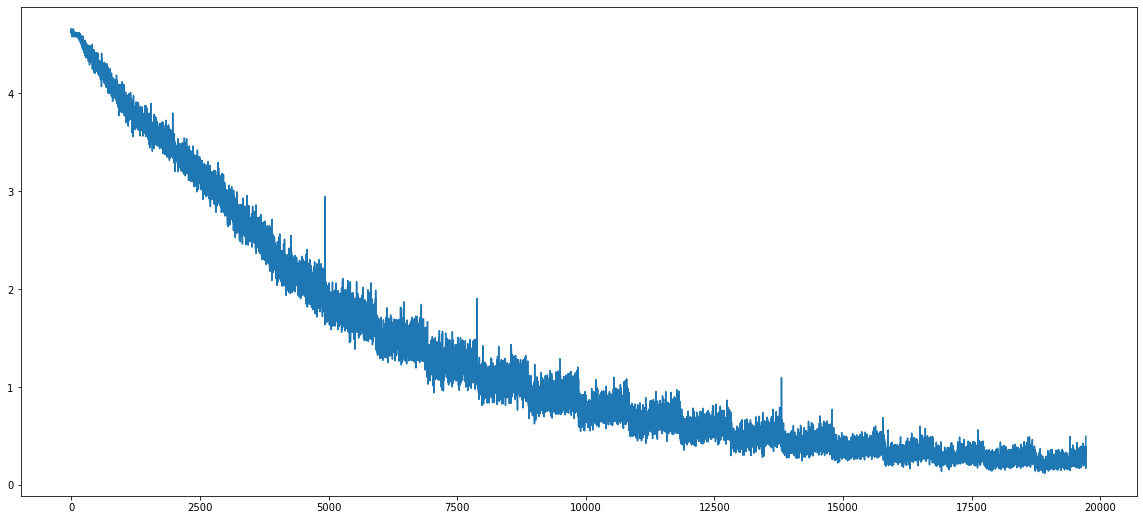

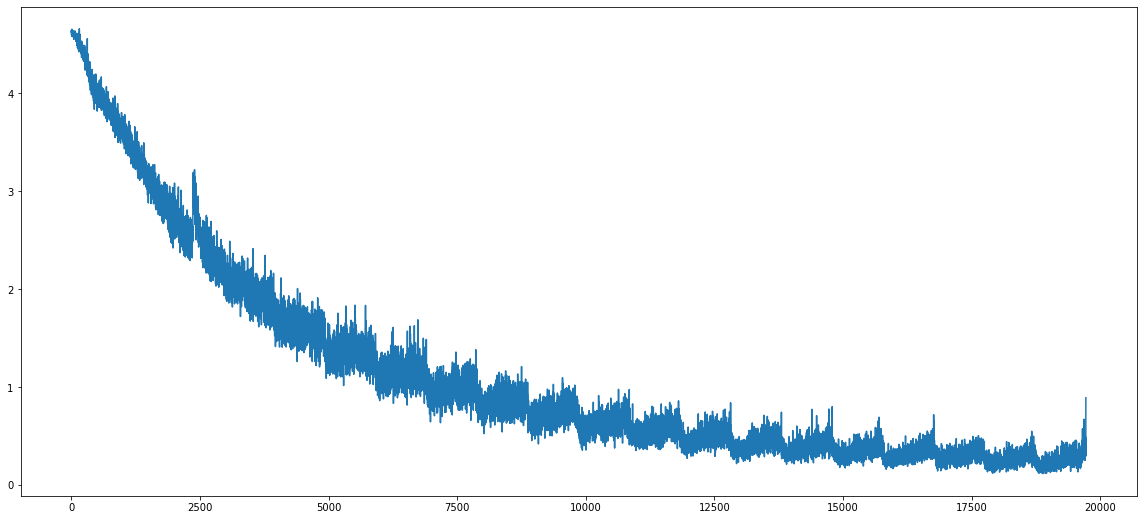

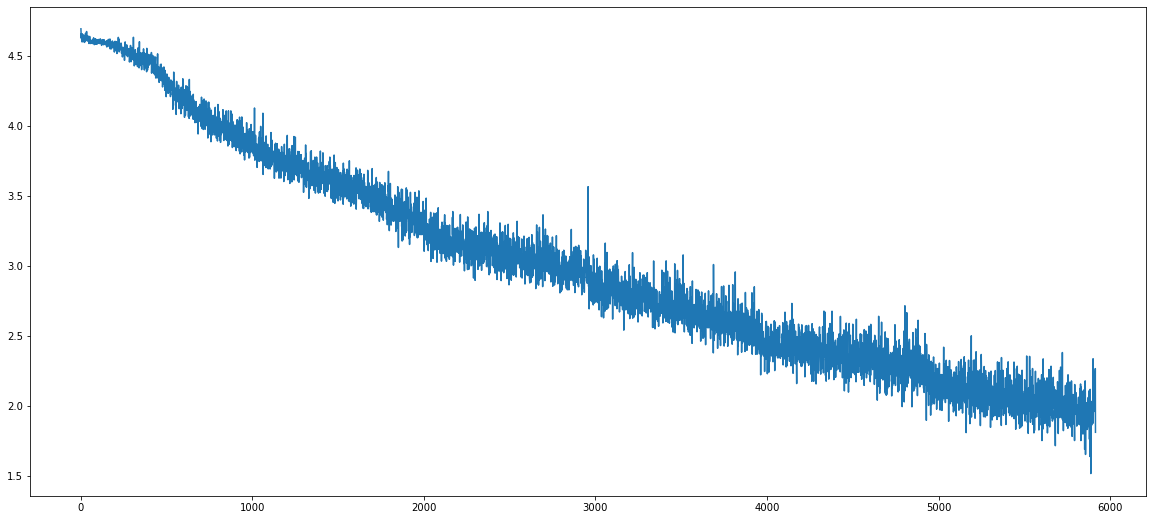

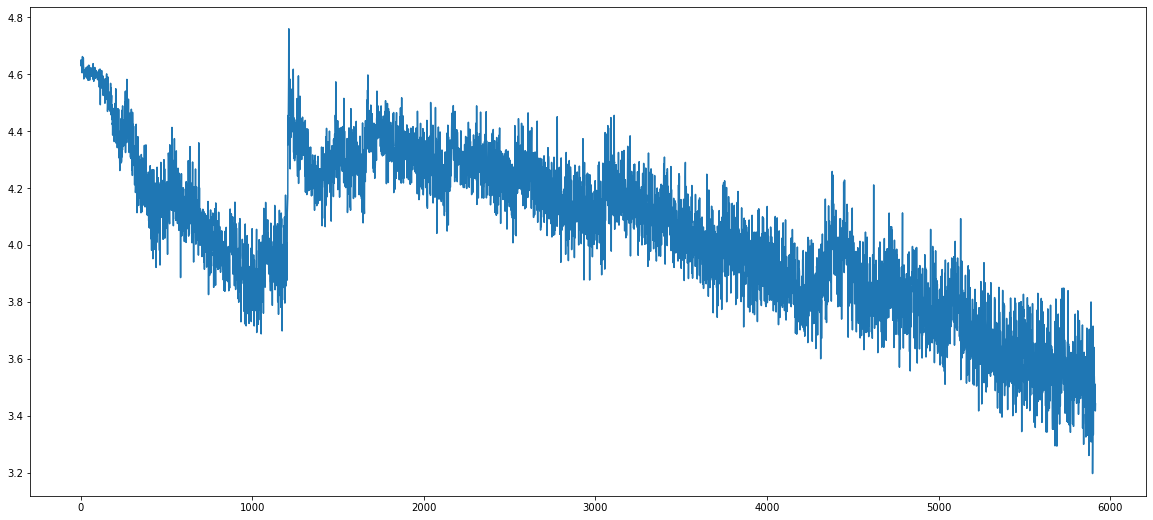

In [16]:
best_params, best_model = param_search()

In [17]:
torch.save(best_model.state_dict(), 'trained_models/model_c_10_lr_002.pth')
store_params(best_prams, 'param_c_10_lr_002')

In [ ]:
"""
20 Classes
--------------------------------------------------
{'valid_acc': tensor(69.6667), 
'train_acc': tensor(81.5015), 
'lr': 0.002, 
'L': 8, 
'N': 128, 
'D': 1024, 
'optim': <class 'torch.optim.adam.Adam'>, 
'enc_layer': 2, 
'fc_dim': 1024, 
'vt_channels': 512, 
'dropout': 0.5, 
'n_head': 1, 
'vt_num_layer': 2}


--------------------------------------------------
10 Classes
--------------------------------------------------
{'valid_acc': tensor(86.), 
'train_acc': tensor(96.7160), 
'lr': 0.002, 
'L': 16, 
'N': 128, 
'D': 1024, 
'optim': <class 'torch.optim.adam.Adam'>, 
'enc_layer': 2, 
'fc_dim': 1024, 
'vt_channels': 512, 
'dropout': 0.5, 
'n_head': 1, 
'vt_num_layer': 2,
'epochs': 10
}

{'valid_acc': tensor(82.5000), 
'train_acc': tensor(89.0350), 
'lr': 0.002, 
'L': 8, 
'N': 128, 
'D': 512, 
'optim': <class 'torch.optim.adam.Adam'>, 
'enc_layer': 3, 
'fc_dim': 1024, 
'vt_channels': 512, 
'dropout': 0.5, 
'n_head': 1, 
'vt_num_layer': 2
}

{'valid_acc': tensor(79.5000), 
'train_acc': tensor(93.3385), 
'lr': 0.002, 
'L': 12, 
'N': 128, 
'D': 1024, 
'optim': <class 
'torch.optim.adam.Adam'>, 
'enc_layer': 2, 
'fc_dim': 1024, 
'vt_channels': 512, 
'dropout': 0.5, 
'n_head': 1, 
'vt_num_layer': 2
}

This Epoch Params:
{'valid_acc': tensor(79.5000), 
'train_acc': tensor(90.5370), 
'lr': 0.002, 
'L': 12, 
'N': 128, 
'D': 1024, 
'optim': <class 'torch.optim.adam.Adam'>, 
'enc_layer': 3, 
'fc_dim': 1024, 
'vt_channels': 512, 
'dropout': 0.5, 
'n_head': 1, 
'vt_num_layer': 2
}


{'valid_acc': tensor(65.5000), 
'train_acc': tensor(64.8560), 
'lr': 0.001, 
'L': 16, 
'N': 128, 
'D': 1024, 
'optim': <class 'torch.optim.adam.Adam'>, 
'enc_layer': 2, 
'fc_dim': 1024, 
'vt_channels': 512, 
'dropout': 0.5, 
'n_head': 1, 
'vt_num_layer': 2,
'epochs:' 5
}
-------------------------------------------------------
"""

In [59]:
model = vt_resnet18(
    pretrained=True,
    tokens=tokens,
    token_channels=token_channels,
    input_dim=input_dim,
    vt_channels=vt_channels,
    transformer_enc_layers=transformer_enc_layers,
    transformer_heads=transformer_heads
)

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [71]:
learning_rates = []
optimizer = Adam(best_model.parameters(), lr=0.001, weight_decay=4e-5)
valid_acc, train_acc, history = train(
    model=best_model, 
    optimizer=optimizer, 
    train_data=train_loader, 
    valid_data=valid_loader,
    epochs=5,
    lr=learning_rate,
    lr_decay=1,
    decay_every=100,
    weight_decay=weight_decay,
    optim=Adam,
    device=device
)

  0%|          | 1/201 [00:00<02:09,  1.54it/s]

[    0/12850 (  0%)]  Loss: 1.1104


 50%|█████     | 101/201 [00:48<00:46,  2.14it/s]

[ 6400/12850 ( 50%)]  Loss: 2.1630


  0%|          | 0/4 [00:00<?, ?it/s]

[10000/12850 (100%)]  Loss: 2.0860
Epoch 0 done.


  0%|          | 0/201 [00:00<?, ?it/s]


Average valid loss: 2.0912  Accuracy:   37/  200 (18.50%)



  0%|          | 0/201 [00:00<?, ?it/s]


Average train loss: 2.1680  Accuracy: 2472/12850 (19.24%)



  0%|          | 1/201 [00:00<01:21,  2.45it/s]

[    0/12850 (  0%)]  Loss: 2.0567


 50%|█████     | 101/201 [00:46<00:46,  2.13it/s]

[ 6400/12850 ( 50%)]  Loss: 2.1320


  0%|          | 0/4 [00:00<?, ?it/s]

[10000/12850 (100%)]  Loss: 2.3320
Epoch 1 done.


  0%|          | 0/201 [00:00<?, ?it/s]


Average valid loss: 2.3081  Accuracy:   19/  200 (9.50%)



 96%|█████████▌| 192/201 [01:21<00:03,  2.35it/s]


ValueError: not enough values to unpack (expected 2, got 0)